In [ ]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


# Импорт библиотек

In [ ]:
!pip install contractions -q
!pip install emoji -q
!pip install -U sentence-transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.6 MB/s eta 0:00:00


In [ ]:
!pip install xgboost==1.6.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.9/192.9 MB 2.6 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.0.2
    Uninstalling xgboost-2.0.2:
      Successfully uninstalled xgboost-2.0.2


In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import contractions
import emoji
import string
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
import xgboost
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import pickle
import torch

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Импорт данных

In [ ]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c nlp-getting-started
!unzip nlp-getting-started.zip

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 33.5MB/s]
Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
test = pd.read_csv('/content/test.csv', usecols=[3])
train = pd.read_csv('/content/train.csv', usecols=[3, 4])

In [ ]:
train

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


<Axes: ylabel='Count'>

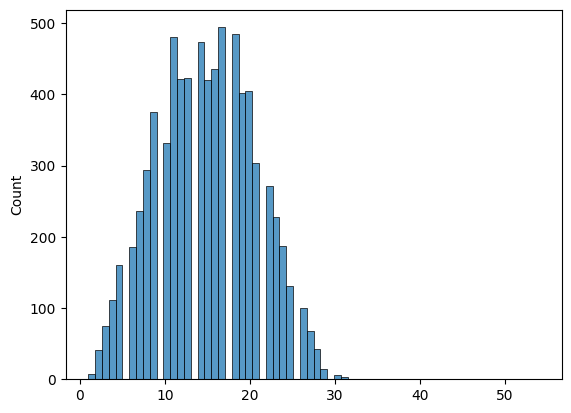

In [ ]:
sns.histplot([len(text.split(' ')) for text in train.text])

# Препроцессинг данных

In [ ]:
def preprocessing(text, stopwords):

  text = ' '.join([contractions.fix(word) for word in text.split()])
  text = ' ' + text + ' '
  text = ' '.join([word for word in text.split() if emoji.is_emoji(word) == False])
  text = ' ' + text + ' '
  text = re.sub(r"[{}]".format(string.punctuation) + '|\n|\t', '', text)
  while re.findall(r'\shttp\S*\s|\swww\S*\s', text):
    text = re.sub(r'\shttp\S*\s|\swww\S*\s', ' ', text)
  while re.findall(r'\sRe\s|\sre\s', text):
    text = re.sub(r'\sRe\s|\sre\s', ' ', text)
  text = re.sub('\d', '', text)
  text = re.sub('\s+', ' ', text)
  text = text.lower()
  text = text.strip()
  text = ' '.join([word for word in text.split() if word not in stopwords])

  return text

In [ ]:
en_stopwords = stopwords.words("english")
additional_stop_words = ['\\a', '\x89û', 'å', 'å£', 'å¤', 'å¨', 'åç', 'åè', 'åê', 'ì¢', 'ìñ', 'ìü']
for word in additional_stop_words:
  en_stopwords.append(word)

In [ ]:
text_prep = train.text.apply(lambda text: preprocessing(text, en_stopwords))
text_prep = text_prep.drop_duplicates()
labels = pd.Series([train.target.loc[index] for index in text_prep.index], index=text_prep.index)

In [ ]:
labels

0       1
1       1
2       1
3       1
4       1
       ..
7601    1
7602    1
7603    1
7605    1
7606    1
Length: 6859, dtype: int64

In [ ]:
text_prep

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       people receive wildfires evacuation orders cal...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7601    breaking la refugio oil spill may costlier big...
7602                    siren went forney tornado warning
7603    officials say quarantine place alabama home po...
7605    flip side walmart bomb everyone evacuate stay ...
7606    suicide bomber kills saudi security site mosqu...
Name: text, Length: 6859, dtype: object

<Axes: ylabel='Count'>

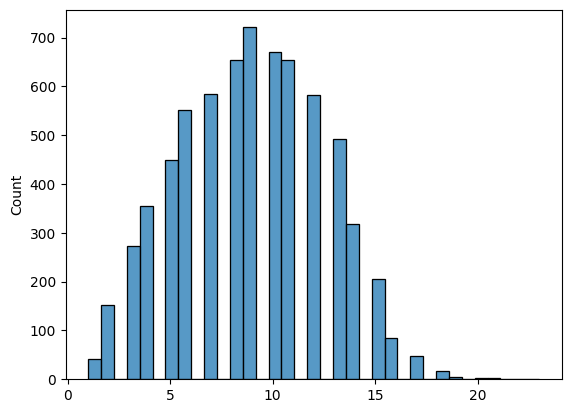

In [ ]:
sns.histplot([len(text.split(' ')) for text in text_prep])

# Эмбединги

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(text_prep, labels, test_size=0.2)

In [ ]:
model = SentenceTransformer('all-mpnet-base-v1')

.gitattributes:   0%|          | 0.00/737 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/9.85k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/591 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
print("Max Sequence Length:", model.max_seq_length)

Max Sequence Length: 512


In [ ]:
print("Max Sequence Length:", model.max_seq_length)
model.max_seq_length = 32
print("Max Sequence Length:", model.max_seq_length)

Max Sequence Length: 512
Max Sequence Length: 32


In [ ]:
X_train.index = range(len(X_train))
X_val.index = range(len(X_val))
Y_train.index = range(len(Y_train))
Y_val.index = range(len(Y_val))

In [ ]:
train_embeddings = model.encode(X_train)
val_embeddings = model.encode(X_val)

# Классификация

## Подбор гиперпараметров

In [ ]:
param_grid = {'n_estimators': [200, 300, 400],
              'max_depth': [6, 8, 10],
              'max_leaves': [0],
              'grow_policy': ['depthwise'],
              'booster': ['gbtree']}

In [ ]:
opt = GridSearchCV(xgboost.XGBClassifier(),
                   param_grid, scoring = ['f1', 'accuracy'], cv=5,
                   verbose=4, error_score='raise', refit=False)

In [ ]:
opt.fit(train_embeddings, Y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END booster=gbtree, grow_policy=depthwise, max_depth=6, max_leaves=0, n_estimators=200; accuracy: (test=0.793) f1: (test=0.728) total time=  16.2s
[CV 2/5] END booster=gbtree, grow_policy=depthwise, max_depth=6, max_leaves=0, n_estimators=200; accuracy: (test=0.789) f1: (test=0.720) total time=  16.3s
[CV 3/5] END booster=gbtree, grow_policy=depthwise, max_depth=6, max_leaves=0, n_estimators=200; accuracy: (test=0.813) f1: (test=0.760) total time=  16.7s
[CV 4/5] END booster=gbtree, grow_policy=depthwise, max_depth=6, max_leaves=0, n_estimators=200; accuracy: (test=0.788) f1: (test=0.723) total time=  16.3s
[CV 5/5] END booster=gbtree, grow_policy=depthwise, max_depth=6, max_leaves=0, n_estimators=200; accuracy: (test=0.802) f1: (test=0.744) total time=  16.7s
[CV 1/5] END booster=gbtree, grow_policy=depthwise, max_depth=6, max_leaves=0, n_estimators=300; accuracy: (test=0.795) f1: (test=0.732) total time=  21.0s
[CV 

GridSearchCV(cv=5, error_score='raise',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'booster': ['gbtree'], 'grow_policy': ['depthwise'],
                         'max_depth': [6, 8, 10], 'max_leaves': [0],
                         'n_estimators': [200, 300, 400]},
             refit=False, scoring=['f1', 'accuracy'], verbose=4)

In [ ]:
another_param_grid = {'n_estimators': [500, 600],
              'max_depth': [12, 14],
              'max_leaves': [0],
              'grow_policy': ['depthwise'],
              'booster': ['gbtree']}

In [ ]:
another_opt = GridSearchCV(xgboost.XGBClassifier(),
                   another_param_grid, scoring = ['f1', 'accuracy'], cv=5,
                   verbose=4, error_score='raise', refit=False)

In [ ]:
another_opt.fit(train_embeddings, Y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END booster=gbtree, grow_policy=depthwise, max_depth=12, max_leaves=0, n_estimators=500; accuracy: (test=0.812) f1: (test=0.753) total time=  31.8s
[CV 2/5] END booster=gbtree, grow_policy=depthwise, max_depth=12, max_leaves=0, n_estimators=500; accuracy: (test=0.798) f1: (test=0.729) total time=  29.5s
[CV 3/5] END booster=gbtree, grow_policy=depthwise, max_depth=12, max_leaves=0, n_estimators=500; accuracy: (test=0.809) f1: (test=0.751) total time=  32.2s
[CV 4/5] END booster=gbtree, grow_policy=depthwise, max_depth=12, max_leaves=0, n_estimators=500; accuracy: (test=0.796) f1: (test=0.731) total time=  29.4s
[CV 5/5] END booster=gbtree, grow_policy=depthwise, max_depth=12, max_leaves=0, n_estimators=500; accuracy: (test=0.800) f1: (test=0.737) total time=  30.4s
[CV 1/5] END booster=gbtree, grow_policy=depthwise, max_depth=12, max_leaves=0, n_estimators=600; accuracy: (test=0.813) f1: (test=0.754) total time=  33.2

GridSearchCV(cv=5, error_score='raise',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'booster': ['gbtree'], 'grow_policy': ['depthwise'],
                         'max_depth': [12, 14], 'max_leaves': [0],
                         'n_estimators': [500, 600]},
             refit=False, scoring=['f1', 'accuracy'], verbose=4)

## Тренируем модель

In [ ]:
clf = xgboost.XGBClassifier(max_depth=8, n_estimators=300, max_leaves=0,
                                 grow_policy='depthwise', booster='gbtree')
clf.fit(train_embeddings, Y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy='depthwise', importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=0,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
predictions = clf.predict(val_embeddings)
print ("Val set f1_score:", np.round(f1_score(Y_val, predictions), 3))
print ("Val set Accuracy_score:", np.round(accuracy_score(Y_val, predictions), 3))

Val set f1_score: 0.742
Val set Accuracy_score: 0.805


In [ ]:
with open("/content/drive/MyDrive/Colab Notebooks/NLP/models_v7/emb_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("/content/drive/MyDrive/Colab Notebooks/NLP/models_v7/clf_model.pkl", "wb") as f:
    pickle.dump(clf, f)

with open("/content/drive/MyDrive/Colab Notebooks/NLP/models_v7/stopwords.pkl", "wb") as f:
    pickle.dump(en_stopwords, f)

## Тест

In [ ]:
test

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan
...,...
3258,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,Storm in RI worse than last hurricane. My city...
3260,Green Line derailment in Chicago http://t.co/U...
3261,MEG issues Hazardous Weather Outlook (HWO) htt...


In [ ]:
test_text_prep = test.text.apply(lambda text: preprocessing(text, en_stopwords))

In [ ]:
test_text_prep.index = range(len(test_text_prep))

In [ ]:
test_embeddings = model.encode(test_text_prep)

In [ ]:
test_predictions = clf.predict(test_embeddings)
sub = pd.read_csv("sample_submission.csv")

sub.target = test_predictions
sub.to_csv('submission.csv', index=False)

# Для сервиса

In [ ]:
def get_res_from_text(text, emb_model, clf_model, stopwords):

  prep_text = preprocessing(text, stopwords)
  embedding = emb_model.encode(prep_text)
  prediction = clf_model.predict(np.array([[i for i in embedding]]))

  return str(prediction[0])

In [ ]:
text = 'Typhoon Soudelor kills 28 in China and Taiwan'
print(get_res_from_text(text, model, clf, en_stopwords))

1
